In [123]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler as min_max_scaler
import numpy as np

In [17]:
import io
import ijson
import pandas as pd
import datetime

cols = ["reviewerID", "asin", "reviewerName", "helpful_start",
        "helpful_end", "reviewText", "overall", "summary",
        "unixReviewTime", "reviewTime"]

reviewerID = []
asin = []
reviewerName = []
helpful_start = []
helpful_end = []
reviewText = []
overall = []
summary = []
unixReviewTime = []
reviewTime = []
helpful = []

a = datetime.datetime.now()

with open('reviews_electronics.15.json', encoding="UTF-8") as json_file:
    cursor = 0
    for line_number, line in enumerate(json_file):
        #print ("Processing line", line_number + 1,"at cursor index:", cursor)
        line_as_file = io.StringIO(line)
        # Use a new parser for each line
        json_parser = ijson.parse(line_as_file)
        for prefix, type, value in json_parser:
            if (type == 'string') | (type == 'number'):
                if prefix.strip() == 'reviewerID':
                    reviewerID.append(value)
                    #print(value)
                elif prefix.strip() == 'asin':
                    asin.append(value)
                elif prefix.strip() == 'reviewerName':
                    reviewerName.append(value)
                elif prefix.strip() == 'helpful.item':
                    helpful.append(value)
                elif prefix.strip() == 'reviewText':
                    reviewText.append(value)
                elif prefix.strip() == 'overall':
                    overall.append(value)
                elif prefix.strip() == 'summary':
                    summary.append(value)
                elif prefix.strip() == 'unixReviewTime':
                    unixReviewTime.append(value)
                elif prefix.strip() == 'reviewTime':
                    reviewTime.append(value)
        cursor += len(line)

        
b = datetime.datetime.now()
       
helpful_start = [helpful[i] for i in range(len(helpful)) if i%2 == 0]
helpful_end = [helpful[i] for i in range(len(helpful)) if i%2 == 1]

review = pd.DataFrame(list(zip(reviewerID, asin, reviewerName, helpful_start, helpful_end,
                           reviewText, overall, summary, unixReviewTime, reviewTime)),
               columns =cols)
c=b-a
print(c.seconds)

42


In [18]:
review.shape

(487582, 10)

In [19]:
review.head()

,reviewerID,asin,reviewerName,helpful_start,helpful_end,reviewText,overall,summary,unixReviewTime,reviewTime
0,AKM1MP6P0OYPR,0132793040,"Vicki Gibson ""momo4""",1,1,Corey Barker does a great job of explaining Bl...,5.0,Very thorough,1365811200,"04 13, 2013"
1,AAQ4R43VELNOZ,B00B1928FE,chichi,1,1,The best deal I have ever got. It fits. Its ex...,4.0,fantastic,1379548800,"09 19, 2013"
2,A2L4CJ0XIJCOI7,B00B1928FE,"Chillaxin ""John""",0,0,I got the blue case and absolutely love it! I...,5.0,"Sturdy, Affordable, Attractive",1392768000,"02 19, 2014"
3,A3UX8PQ8K5MFUC,B00B1928FE,chris,0,0,Overall this case is exactly what it shows. D...,4.0,for the price great product!!!!!!!!,1389571200,"01 13, 2014"
4,AMC2IIWQI6HNQ,B00B1928FE,Christabel Ortega,0,0,Didn't fit the tablet that I bought it for. It...,1.0,Didn't fit,1399939200,"05 13, 2014"


In [22]:
review['reviewText'][4]

"Didn't fit the tablet that I bought it for. It lists the tablet but it doesn't fit with the proper openings for each hole."

#### 1. Treat each review as a document. Ignore misspellings. Convert all reviews to lower case. Remove stop words (use package to do this).


In [23]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiaxuewan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jiaxuewan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
df1 = review.copy(deep = True) # clone dataset
stop_words = stopwords.words('english')
a = datetime.datetime.now()
df1['reviewText'] = df1['reviewText'].map(lambda text : [x for x in word_tokenize(text.lower()) if not x in stop_words])
b = datetime.datetime.now()
print(b-a)

0:05:08.288235


#### 2. Handle negation: Look for the following two negations: "not" and "xxxn't" (e.g., don't, didn't etc.). Split off the "n't" part from "xxxn't" into separate words "xxx" and "not". Attach all 'not's (any normal "not" appearing in the text as well as the "n't" converted to "not") to the subsequent word, eg "not_nextword" (code this yourself).

In [86]:
# handle negation first
df2 = review.copy(deep = True)
df2 = df2.replace(to_replace ="n't ", value = ' not_', regex = True)
df2 = df2.replace(to_replace ="not ", value = ' not_', regex = True)

In [87]:
import string
string.punctuation = string.punctuation.replace('_','')

In [88]:
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s

df2["reviewText"] = df2['reviewText'].apply(remove_punctuation)
df2.head()

,reviewerID,asin,reviewerName,helpful_start,helpful_end,reviewText,overall,summary,unixReviewTime,reviewTime
0,AKM1MP6P0OYPR,0132793040,"Vicki Gibson ""momo4""",1,1,Corey Barker does a great job of explaining Bl...,5.0,Very thorough,1365811200,"04 13, 2013"
1,AAQ4R43VELNOZ,B00B1928FE,chichi,1,1,The best deal I have ever got It fits Its exca...,4.0,fantastic,1379548800,"09 19, 2013"
2,A2L4CJ0XIJCOI7,B00B1928FE,"Chillaxin ""John""",0,0,I got the blue case and absolutely love it It...,5.0,"Sturdy, Affordable, Attractive",1392768000,"02 19, 2014"
3,A3UX8PQ8K5MFUC,B00B1928FE,chris,0,0,Overall this case is exactly what it shows Du...,4.0,for the price great product!!!!!!!!,1389571200,"01 13, 2014"
4,AMC2IIWQI6HNQ,B00B1928FE,Christabel Ortega,0,0,Did not_fit the tablet that I bought it for It...,1.0,Did not_fit,1399939200,"05 13, 2014"


In [89]:
# remove stop words
stop_words = stopwords.words('english')
a = datetime.datetime.now()

df2['reviewText'] = df2['reviewText'].map(lambda text : word_tokenize(''.join(s for s in text.lower())))
df2['reviewText'] = df2['reviewText'].map(lambda text_list : [x for x in text_list if not x in stop_words])

b = datetime.datetime.now()
print(b-a)

0:09:44.322792


In [90]:
df2.head()

,reviewerID,asin,reviewerName,helpful_start,helpful_end,reviewText,overall,summary,unixReviewTime,reviewTime
0,AKM1MP6P0OYPR,0132793040,"Vicki Gibson ""momo4""",1,1,"[corey, barker, great, job, explaining, blend,...",5.0,Very thorough,1365811200,"04 13, 2013"
1,AAQ4R43VELNOZ,B00B1928FE,chichi,1,1,"[best, deal, ever, got, fits, excatly, expecte...",4.0,fantastic,1379548800,"09 19, 2013"
2,A2L4CJ0XIJCOI7,B00B1928FE,"Chillaxin ""John""",0,0,"[got, blue, case, absolutely, love, well, made...",5.0,"Sturdy, Affordable, Attractive",1392768000,"02 19, 2014"
3,A3UX8PQ8K5MFUC,B00B1928FE,chris,0,0,"[overall, case, exactly, shows, durablity, far...",4.0,for the price great product!!!!!!!!,1389571200,"01 13, 2014"
4,AMC2IIWQI6HNQ,B00B1928FE,Christabel Ortega,0,0,"[not_fit, tablet, bought, lists, tablet, not_f...",1.0,Did not_fit,1399939200,"05 13, 2014"


#### 3. Stem all words using Porter 1979 (use package to do this).

In [91]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
a = datetime.datetime.now()
df2['reviewText'] = df2['reviewText'].map(lambda text_list : [ps.stem(x) for x in text_list])
b = datetime.datetime.now()
print(b-a)

0:08:02.610340


#### 4. Create frequency count table for all word stems in all reviews (this will be big). Use the most frequent 500 words to define the word vector. Create a bag-of-word vector representation for each review in electronics

In [92]:
from collections import Counter 
from itertools import chain
import string

# put all review into a flattened list
review_list = list(chain.from_iterable(df2['reviewText'].tolist()))

# 500 table
most_occur = Counter(review_list).most_common(500) 

# create dict for index
bow_index, i = {}, 0
for k in dict(most_occur).keys():
    bow_index[k] = i
    i += 1


In [93]:
#bow_index
most_occur

[('use', 254315),
 ('work', 200570),
 ('one', 170531),
 ('great', 170131),
 ('would', 143815),
 ('like', 137291),
 ('good', 127219),
 ('get', 126407),
 ('case', 117679),
 ('well', 101744),
 ('product', 101446),
 ('time', 98032),
 ('tv', 91709),
 ('look', 90448),
 ('need', 83449),
 ('sound', 80675),
 ('price', 79825),
 ('camera', 78488),
 ('love', 77478),
 ('screen', 76935),
 ('also', 74796),
 ('devic', 73856),
 ('tablet', 73025),
 ('qualiti', 72916),
 ('realli', 71792),
 ('easi', 70503),
 ('much', 62732),
 ('make', 62711),
 ('im', 62682),
 ('set', 62227),
 ('bought', 62014),
 ('fit', 61823),
 ('batteri', 61807),
 ('purchas', 61474),
 ('nice', 60855),
 ('want', 60823),
 ('littl', 60130),
 ('charg', 60101),
 ('buy', 59531),
 ('could', 59104),
 ('thing', 58935),
 ('cabl', 58892),
 ('phone', 57361),
 ('back', 57272),
 ('go', 56817),
 ('recommend', 55458),
 ('better', 55418),
 ('problem', 55187),
 ('connect', 54948),
 ('even', 53481),
 ('keyboard', 53063),
 ('tri', 52443),
 ('got', 52255),


In [94]:
def q4(l):
    '''
    generate bow vector for each review
    l: each review(list)
    '''
    bow_vector = [0]*500
    for i in l:
        if i in bow_index:
            bow_vector[bow_index[i]] = 1
    return bow_vector
a = datetime.datetime.now()
df2['bow_vector'] = df2['reviewText'].map(lambda x: q4(x))
b = datetime.datetime.now()
print(b-a)

0:01:57.933111


In [95]:
# check
df2['bow_vector'].iloc[1]

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


#### 5. Establish a method for measuring the distance between different reviews. Print the mutual distance between the first 100 reviews (review IDs) to screen, sorted from closest to furthest.

In [96]:
import math

# get first 100 reviews
bow_vector_100 = list(df2[:100]['bow_vector'])

# calculate euclidean distance
distance_100 = [[math.sqrt(sum((i[k] - j[k])**2 for k in range(500))) 
                for j in bow_vector_100]
            for i in bow_vector_100]
distance_100

[[0.0,
  4.242640687119285,
  4.358898943540674,
  5.656854249492381,
  3.3166247903554,
  5.477225575051661,
  3.605551275463989,
  3.4641016151377544,
  3.872983346207417,
  4.898979485566356,
  5.0990195135927845,
  5.0,
  4.58257569495584,
  3.7416573867739413,
  3.7416573867739413,
  4.0,
  4.58257569495584,
  3.872983346207417,
  3.872983346207417,
  3.872983346207417,
  5.477225575051661,
  5.196152422706632,
  4.358898943540674,
  4.898979485566356,
  5.0990195135927845,
  4.358898943540674,
  6.557438524302,
  3.872983346207417,
  4.69041575982343,
  4.69041575982343,
  4.123105625617661,
  4.47213595499958,
  4.0,
  4.123105625617661,
  4.358898943540674,
  4.123105625617661,
  4.242640687119285,
  4.123105625617661,
  4.242640687119285,
  3.605551275463989,
  4.58257569495584,
  5.830951894845301,
  4.58257569495584,
  4.69041575982343,
  4.898979485566356,
  3.4641016151377544,
  4.0,
  4.242640687119285,
  3.3166247903554,
  4.0,
  3.872983346207417,
  4.242640687119285,
 

In [97]:
# sort

import operator
distance_100_sorted = {}
for i in range(100):
    for j in range(100):
        if i != j: distance_100_sorted[(i,j)] = distance_100[i][j]
distance_100_sorted = sorted(distance_100_sorted.items(), key = operator.itemgetter(1))
distance_100_sorted

[((62, 93), 2.0),
 ((93, 62), 2.0),
 ((4, 93), 2.23606797749979),
 ((39, 62), 2.23606797749979),
 ((39, 93), 2.23606797749979),
 ((48, 93), 2.23606797749979),
 ((62, 39), 2.23606797749979),
 ((93, 4), 2.23606797749979),
 ((93, 39), 2.23606797749979),
 ((93, 48), 2.23606797749979),
 ((4, 39), 2.449489742783178),
 ((4, 92), 2.449489742783178),
 ((7, 93), 2.449489742783178),
 ((13, 93), 2.449489742783178),
 ((39, 4), 2.449489742783178),
 ((57, 93), 2.449489742783178),
 ((78, 93), 2.449489742783178),
 ((92, 4), 2.449489742783178),
 ((93, 7), 2.449489742783178),
 ((93, 13), 2.449489742783178),
 ((93, 57), 2.449489742783178),
 ((93, 78), 2.449489742783178),
 ((4, 7), 2.6457513110645907),
 ((4, 57), 2.6457513110645907),
 ((4, 59), 2.6457513110645907),
 ((7, 4), 2.6457513110645907),
 ((7, 48), 2.6457513110645907),
 ((18, 93), 2.6457513110645907),
 ((19, 93), 2.6457513110645907),
 ((27, 51), 2.6457513110645907),
 ((27, 93), 2.6457513110645907),
 ((30, 93), 2.6457513110645907),
 ((37, 93), 2.645

#### 6. Run a PCA and graph the first two PCs for the first 100 reviews. Does your graph reflect your findings from the previous exercise?

In [98]:
# create one dictionary to save the first 100 bow vectors
bow_vector_100_dict = {}

# merge the first 100 bow vectors into one dictionary
for k in tqdm(bow_index.keys()):
    bow_vector_100_dict[k] = [i[bow_index[k]] for i in bow_vector_100]

# convert the dictionary into a dataframe
bow_dataframe_100 = pd.DataFrame(bow_vector_100_dict)
bow_dataframe_100


100%|██████████| 500/500 [00:00<00:00, 548.86it/s]


,use,work,one,great,would,like,good,get,case,well,...,care,leav,6,except,consol,happen,magnet,simpli,daughter,hub
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
96,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
97,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [99]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(bow_dataframe_100)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,-0.729492,0.462596
1,-0.254941,0.493592
2,-0.659345,0.032034
3,1.050797,-0.968219
4,-0.861069,0.343546
...,...,...
95,0.044630,-0.577627
96,0.490386,-0.198153
97,-0.716817,0.238837
98,0.247605,0.110718


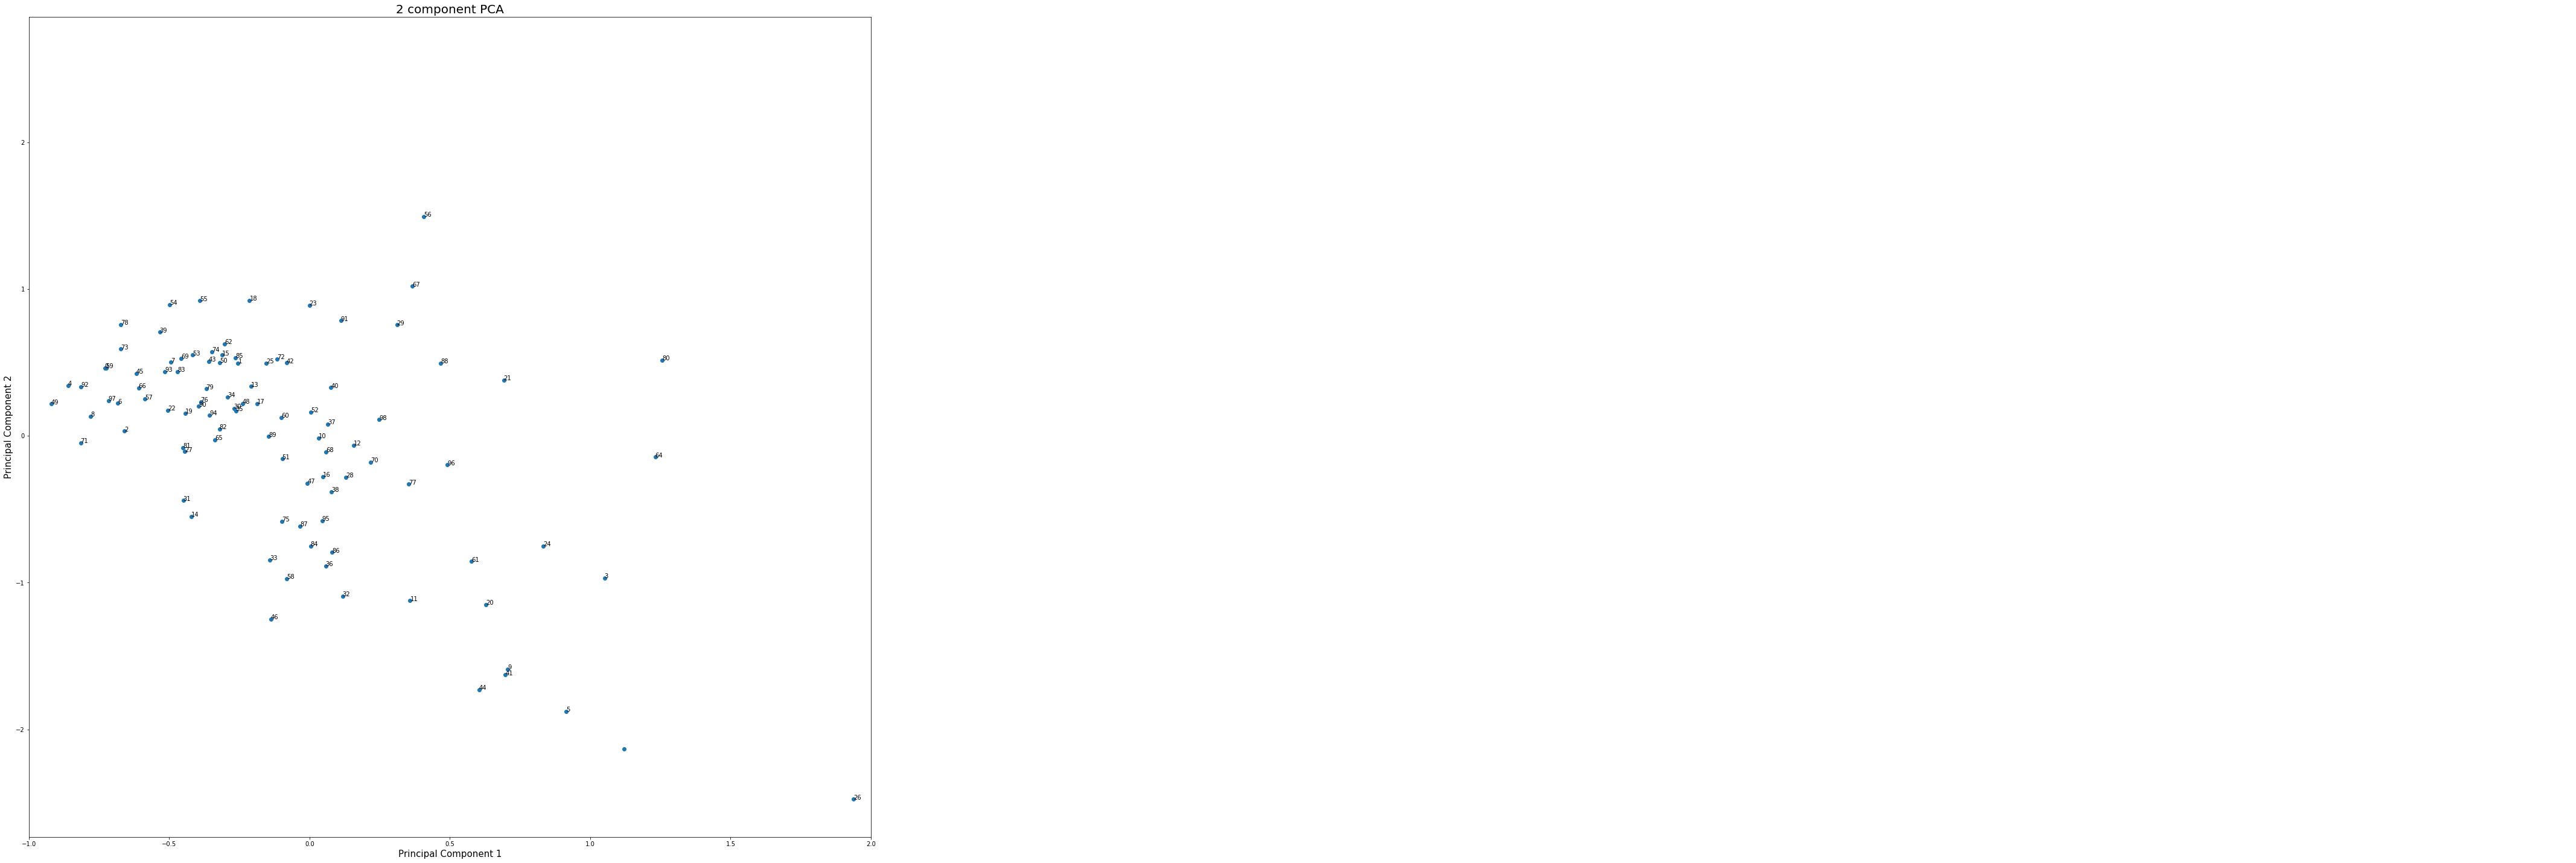

In [100]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'],principalDf['principal component 2'])
ax.set_xlim((-1,2))
nums = list(range(0,99))
for i, txt in enumerate(nums):
    ax.annotate(txt, (principalDf['principal component 1'][i], principalDf['principal component 2'][i]))

#### 8. Perform a lasso logistic regression and measure the out-of-sample accuracy of your method of choice.

In [101]:
df2.head()

,reviewerID,asin,reviewerName,helpful_start,helpful_end,reviewText,overall,summary,unixReviewTime,reviewTime,bow_vector
0,AKM1MP6P0OYPR,0132793040,"Vicki Gibson ""momo4""",1,1,"[corey, barker, great, job, explain, blend, mo...",5.0,Very thorough,1365811200,"04 13, 2013","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,AAQ4R43VELNOZ,B00B1928FE,chichi,1,1,"[best, deal, ever, got, fit, excatli, expect, ...",4.0,fantastic,1379548800,"09 19, 2013","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,A2L4CJ0XIJCOI7,B00B1928FE,"Chillaxin ""John""",0,0,"[got, blue, case, absolut, love, well, made, s...",5.0,"Sturdy, Affordable, Attractive",1392768000,"02 19, 2014","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
3,A3UX8PQ8K5MFUC,B00B1928FE,chris,0,0,"[overal, case, exactli, show, durabl, far, prt...",4.0,for the price great product!!!!!!!!,1389571200,"01 13, 2014","[0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
4,AMC2IIWQI6HNQ,B00B1928FE,Christabel Ortega,0,0,"[not_fit, tablet, bought, list, tablet, not_fi...",1.0,Did not_fit,1399939200,"05 13, 2014","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [102]:
bow_vector_all = list(df2['bow_vector'])

In [103]:
# create one dictionary to save all the bow vectors
bow_vector_dict = {}

# merge the first 100 bow vectors into one dictionary
for k in tqdm(bow_index.keys()):
    bow_vector_dict[k] = [i[bow_index[k]] for i in bow_vector_all]

# convert the dictionary into a dataframe
bow_df = pd.DataFrame(bow_vector_dict)
bow_df


100%|██████████| 500/500 [01:01<00:00,  8.13it/s]


,use,work,one,great,would,like,good,get,case,well,...,care,leav,6,except,consol,happen,magnet,simpli,daughter,hub
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487577,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
487578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
487579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
487580,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [104]:
rating_bow_vector = bow_df.merge(df2['overall'],left_index = True, right_index = True)
rating_bow_vector

,use,work,one,great,would,like,good,get,case,well,...,leav,6,except,consol,happen,magnet,simpli,daughter,hub,overall
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5.0
3,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,4.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487577,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
487578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
487579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
487580,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,5.0


In [141]:
y = rating_bow_vector['overall'].apply(lambda x: int(x))
x = rating_bow_vector.drop('overall',axis = 1)

In [142]:
x

,use,work,one,great,would,like,good,get,case,well,...,care,leav,6,except,consol,happen,magnet,simpli,daughter,hub
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487577,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
487578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
487579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
487580,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [143]:
y

0         5
1         4
2         5
3         4
4         1
         ..
487577    4
487578    5
487579    5
487580    5
487581    5
Name: overall, Length: 487582, dtype: int64

In [138]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from mord import LogisticAT

In [139]:
def accuracy_or(true,fit):
    fit = np.round(fit)
    fit.astype('int')
    return accuracy_score(true,fit)

In [144]:
model_ordinal = LogisticAT(alpha=1)
accuracy = make_scorer(accuracy_or)
acc_ordinal = cross_val_score(model_ordinal,x,y,cv = 3,scoring = accuracy)
np.mean(acc_ordinal)

0.5520978929999011


#### 9. Implement a method to aggregate reviews by product. Can you use any of the other columns to help with aggregation? Explain why or why not. Please clearly explain your method.

In [161]:
product_review = pd.DataFrame(df2.groupby('asin')['bow_vector'].apply(list))
product_review 

,bow_vector
asin,
0132793040,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
B00B1928FE,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
B00B193IGC,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
B00B195OPK,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,..."
B00B1960KS,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...
B00E35UW2Y,"[[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,..."
B00E35XVI6,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,..."
B00E360N40,"[[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,..."


In [162]:
len(product_review ['bow_vector'][5])

25

In [163]:
# calculate average bow vector for each product
a = datetime.datetime.now()
product_review['avg_bow_vector'] = product_review['bow_vector'].apply(lambda l: [sum(item)/len(l) for item in zip(*l)])
b = datetime.datetime.now()
print(b - a)

0:07:12.377787


In [164]:
product_review['avg_bow_vector']

asin
0132793040    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
B00B1928FE    [0.15742128935532235, 0.12143928035982009, 0.1...
B00B193IGC    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
B00B195OPK    [0.47619047619047616, 0.6666666666666666, 0.38...
B00B1960KS    [0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, ...
                                    ...                        
B00E35UW2Y    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
B00E35XVI6    [0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, ...
B00E360N40    [0.0, 0.3333333333333333, 0.6666666666666666, ...
B00E3623FC    [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...
B00E362W9O    [0.4, 0.4222222222222222, 0.26666666666666666,...
Name: avg_bow_vector, Length: 38215, dtype: object


#### 10. Establish a method for measuring the distance between different products.


In [202]:
# We use 10 products to explain the method
unique_products = list(df2['asin'].unique()[61:71])
unique_products

['B00B1F7IEE',
 'B00B1FBRGO',
 'B00B1FD8YS',
 'B00B1FDCYO',
 'B00B1FDF8M',
 'B00B1FEXA6',
 'B00B1FG32C',
 'B00B1FI7VM',
 'B00B1FK5JY',
 'B00B1FKO3G']

In [189]:
product_review_10 = product_review[61:71]

In [190]:
product_review_10 = product_review_10.reset_index()

In [191]:
product_review_10

,asin,bow_vector,avg_bow_vector
0,B00B1F7IEE,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.4772727272727273, 0.4772727272727273, 0.272..."
1,B00B1FBRGO,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,B00B1FD8YS,"[[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[1.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, ..."
3,B00B1FDCYO,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,B00B1FDF8M,"[[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
5,B00B1FEXA6,"[[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
6,B00B1FG32C,"[[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
7,B00B1FI7VM,"[[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.3333333333333333, 0.3333333333333333, 0.0, ..."
8,B00B1FK5JY,"[[0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,B00B1FKO3G,"[[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."


In [203]:
prod_dist = dict()
for i in range(0,10):
    for j in range(i+1,10):
        x = math.sqrt(sum((p-q)**2 for p, q in zip(product_review_10.loc[i,'avg_bow_vector'], product_review_10.loc[j,'avg_bow_vector'])))
        #x = math.sqrt(sum((list(vector_df.loc[i]) - list(vector_df.loc[j]))**2))
        prod_dist.update({(unique_products[i],unique_products[j]):x})
    print(i)
    


0
1
2
3
4
5
6
7
8
9


In [204]:
prod_dist

{('B00B1F7IEE', 'B00B1FBRGO'): 2.040650925157735,
 ('B00B1F7IEE', 'B00B1FD8YS'): 2.633815382876029,
 ('B00B1F7IEE', 'B00B1FDCYO'): 2.6251721706623097,
 ('B00B1F7IEE', 'B00B1FDF8M'): 4.076616446624885,
 ('B00B1F7IEE', 'B00B1FEXA6'): 4.093307377812732,
 ('B00B1F7IEE', 'B00B1FG32C'): 3.0121997124091897,
 ('B00B1F7IEE', 'B00B1FI7VM'): 1.8573880362795934,
 ('B00B1F7IEE', 'B00B1FK5JY'): 6.047590190103666,
 ('B00B1F7IEE', 'B00B1FKO3G'): 10.710261936283407,
 ('B00B1FBRGO', 'B00B1FD8YS'): 2.449489742783178,
 ('B00B1FBRGO', 'B00B1FDCYO'): 2.0,
 ('B00B1FBRGO', 'B00B1FDF8M'): 4.242640687119285,
 ('B00B1FBRGO', 'B00B1FEXA6'): 3.872983346207417,
 ('B00B1FBRGO', 'B00B1FG32C'): 2.6457513110645907,
 ('B00B1FBRGO', 'B00B1FI7VM'): 1.328695638122379,
 ('B00B1FBRGO', 'B00B1FK5JY'): 6.244997998398398,
 ('B00B1FBRGO', 'B00B1FKO3G'): 11.40175425099138,
 ('B00B1FD8YS', 'B00B1FDCYO'): 2.6457513110645907,
 ('B00B1FD8YS', 'B00B1FDF8M'): 4.58257569495584,
 ('B00B1FD8YS', 'B00B1FEXA6'): 4.47213595499958,
 ('B00B1FD